In [125]:
# gerekli kütüphaneleri yükleme
import numpy as np
import pandas as pd 
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/gezinomi/miuul_gezinomi.xlsx


In [56]:
# veri setini yükleme
file_path = "/kaggle/input/gezinomi/miuul_gezinomi.xlsx"
df = pd.read_excel(file_path)

In [57]:
df.head()

,SaleId,SaleDate,CheckInDate,Price,ConceptName,SaleCityName,CInDay,SaleCheckInDayDiff,Seasons
0,415122,2022-12-03,2022-12-03,79.304029,Herşey Dahil,Antalya,Saturday,0,Low
1,415103,2022-12-03,2022-12-03,45.970696,Yarım Pansiyon,Antalya,Saturday,0,Low
2,404034,2022-09-12,2022-09-13,77.838828,Herşey Dahil,Antalya,Tuesday,1,High
3,415094,2022-12-03,2022-12-10,222.710623,Yarım Pansiyon,İzmir,Saturday,7,Low
4,414951,2022-12-01,2022-12-03,140.476190,Yarım Pansiyon,İzmir,Saturday,2,Low


## **1. Veri Setine Genel Bakış**
Bu adımda, veri setini analiz etmek için bir <code>explore_data</code> fonksiyonu oluşturacağız:
- İlk 5 gözlem birimini görüntülemek
- Değişken adlarını listelemek
- Boş değerleri kontrol etmek
- Bellek kullanımını ve veri setinin boyutunu görüntülemek
- Numerik değişkenler için temel istatistikler sağlamak

In [58]:
def explore_data(dataframe):
    print("İlk 5 gözlem:")
    print(dataframe.head())
    print("\n")
    
    print("Değişken adları ve türleri:")
    print(dataframe.info())
    print("\n")
    
    print("Boş değerlerin sayısı:")
    print(dataframe.isnull().sum())
    print("\n")
    
    print("Veri setinin boyutu:")
    print(dataframe.shape)
    print("\n")
    
    print("Numerik değişkenler için temel istatistikler:")
    print(dataframe.describe())
    print("\n")

In [59]:
explore_data(df)

İlk 5 gözlem:
   SaleId   SaleDate CheckInDate       Price     ConceptName SaleCityName  \
0  415122 2022-12-03  2022-12-03   79.304029    Herşey Dahil      Antalya   
1  415103 2022-12-03  2022-12-03   45.970696  Yarım Pansiyon      Antalya   
2  404034 2022-09-12  2022-09-13   77.838828    Herşey Dahil      Antalya   
3  415094 2022-12-03  2022-12-10  222.710623  Yarım Pansiyon        İzmir   
4  414951 2022-12-01  2022-12-03  140.476190  Yarım Pansiyon        İzmir   

     CInDay  SaleCheckInDayDiff Seasons  
0  Saturday                   0     Low  
1  Saturday                   0     Low  
2   Tuesday                   1    High  
3  Saturday                   7     Low  
4  Saturday                   2     Low  


Değişken adları ve türleri:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59164 entries, 0 to 59163
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   SaleId          

In [60]:
# Boş değerlerin toplam sayısını kontrol etmek
missing_values = df.isnull().sum()
print("Boş değer sayıları: ", missing_values)

Boş değer sayıları:  SaleId                 0
SaleDate               0
CheckInDate            0
Price                 13
ConceptName            0
SaleCityName           0
CInDay                 0
SaleCheckInDayDiff     0
Seasons                0
dtype: int64


In [61]:
# veri setinin toplam satır sayısı
total_rows = df.shape[0]

missing_rows = df[df["Price"].isnull()].shape[0]
missing_ratio = missing_rows / total_rows

print(f"Toplam satır sayısı: {total_rows}")
print(f"'Price' sütununda boş değer içeren satır sayısı: {missing_rows}")
print(f"Boş değer oranı: {missing_ratio:.2%}")

Toplam satır sayısı: 59164
'Price' sütununda boş değer içeren satır sayısı: 13
Boş değer oranı: 0.02%


#### **Boş Verilerin Temizlenmesi: **

Toplam satır sayısı 59,164 ve price sütunundaki boş değer sayısı 13tür. Boş verilerin oranı yalnızca <code> %0.02</code> gibi çok küçük bir değere sahiptir. Bu düşük oran, veri kaybının önemsiz olduğunu gösterir ve bu nedenle boş değer içeren satırları temizlemek makul bir çözümdür.

<code>dropna()</code> fonksiyonu kullanılarak **Price** sütununda boş değer içeren satırlar veri setinden kaldırıldı.

In [62]:
# Orijinal veri seti üzerinde temizleme işlemi
df = df.dropna(subset=['Price'])

In [63]:
# Temizlenmiş veri setinin boyutu
print(f"Temizlenmiş veri setinin boyutu: {df_cleaned.shape}")

Temizlenmiş veri setinin boyutu: (59151, 9)


In [64]:
# Temizlenmiş veri setinde boş değer kontrolü
print(df.isnull().sum())

SaleId                0
SaleDate              0
CheckInDate           0
Price                 0
ConceptName           0
SaleCityName          0
CInDay                0
SaleCheckInDayDiff    0
Seasons               0
dtype: int64


## **2. Özellik Mühendisliği**

### 2.1 Tarihten Yeni Özellikler Türetme

In [65]:
# "CheckIn" değişkenini datetime formatına çevirme
df["CheckInDate"] = pd.to_datetime(df["CheckInDate"])

In [66]:
# yeni değişkenler türetme
df["CheckInYear"] = df["CheckInDate"].dt.year
df["CheckInMonth"] = df["CheckInDate"].dt.month
df["CheckInDay"] = df["CheckInDate"].dt.day
df["CheckInWeekday"] = df["CheckInDate"].dt.weekday
df["IsWeekend"] = df["CheckInDate"].apply(lambda x: 1 if x.weekday() >=5 else 0) # weekday haftanın günlerini döndürür

In [67]:
# İlk 5 satırı görüntüleme
df[['CheckInDate', 'CheckInYear', 'CheckInMonth', 'CheckInDay', 'CheckInWeekday', 'IsWeekend']].head()

,CheckInDate,CheckInYear,CheckInMonth,CheckInDay,CheckInWeekday,IsWeekend
0,2022-12-03,2022,12,3,5,1
1,2022-12-03,2022,12,3,5,1
2,2022-09-13,2022,9,13,1,0
3,2022-12-10,2022,12,10,5,1
4,2022-12-03,2022,12,3,5,1


In [68]:
earliest_date = df["CheckInDate"].min()
latest_date = df["CheckInDate"].max()

print(f"CheckInDate sütunu {earliest_date} ile {latest_date} tarihleri arasında.")

CheckInDate sütunu 2007-07-20 00:00:00 ile 2023-08-16 00:00:00 tarihleri arasında.


### 2.2 Tatil Türleri Ekleme

In [69]:
# Türkiye'nin resmi tatilleri ve dini bayram tarihleri
holidays = [
    # Resmi Tatiller
    "2007-01-01", "2007-04-23", "2007-05-01", "2007-05-19", "2007-08-30", "2007-10-29",
    "2008-01-01", "2008-04-23", "2008-05-01", "2008-05-19", "2008-08-30", "2008-10-29",
    "2009-01-01", "2009-04-23", "2009-05-01", "2009-05-19", "2009-08-30", "2009-10-29",
    "2010-01-01", "2010-04-23", "2010-05-01", "2010-05-19", "2010-08-30", "2010-10-29",
    "2011-01-01", "2011-04-23", "2011-05-01", "2011-05-19", "2011-08-30", "2011-10-29",
    "2012-01-01", "2012-04-23", "2012-05-01", "2012-05-19", "2012-08-30", "2012-10-29",
    "2013-01-01", "2013-04-23", "2013-05-01", "2013-05-19", "2013-08-30", "2013-10-29",
    "2014-01-01", "2014-04-23", "2014-05-01", "2014-05-19", "2014-08-30", "2014-10-29",
    "2015-01-01", "2015-04-23", "2015-05-01", "2015-05-19", "2015-08-30", "2015-10-29",
    "2016-01-01", "2016-04-23", "2016-05-01", "2016-05-19", "2016-08-30", "2016-10-29",
    "2017-01-01", "2017-04-23", "2017-05-01", "2017-05-19", "2017-08-30", "2017-10-29",
    "2018-01-01", "2018-04-23", "2018-05-01", "2018-05-19", "2018-08-30", "2018-10-29",
    "2019-01-01", "2019-04-23", "2019-05-01", "2019-05-19", "2019-08-30", "2019-10-29",
    "2020-01-01", "2020-04-23", "2020-05-01", "2020-05-19", "2020-08-30", "2020-10-29",
    "2021-01-01", "2021-04-23", "2021-05-01", "2021-05-19", "2021-08-30", "2021-10-29",
    "2022-01-01", "2022-04-23", "2022-05-01", "2022-05-19", "2022-08-30", "2022-10-29",
    "2023-01-01", "2023-04-23", "2023-05-01", "2023-05-19", "2023-08-30", "2023-10-29",
    
    # Ramazan Bayramı
    "2007-10-12", "2007-10-13", "2007-10-14",
    "2008-09-30", "2008-10-01", "2008-10-02",
    "2009-09-20", "2009-09-21", "2009-09-22",
    "2010-09-09", "2010-09-10", "2010-09-11",
    "2011-08-30", "2011-08-31", "2011-09-01",
    "2012-08-19", "2012-08-20", "2012-08-21",
    "2013-08-08", "2013-08-09", "2013-08-10",
    "2014-07-28", "2014-07-29", "2014-07-30",
    "2015-07-17", "2015-07-18", "2015-07-19",
    "2016-07-05", "2016-07-06", "2016-07-07",
    "2017-06-25", "2017-06-26", "2017-06-27",
    "2018-06-15", "2018-06-16", "2018-06-17",
    "2019-06-04", "2019-06-05", "2019-06-06",
    "2020-05-24", "2020-05-25", "2020-05-26",
    "2021-05-13", "2021-05-14", "2021-05-15",
    "2022-05-02", "2022-05-03", "2022-05-04",
    "2023-04-21", "2023-04-22", "2023-04-23",
    
    # Kurban Bayramı
    "2007-12-20", "2007-12-21", "2007-12-22", "2007-12-23",
    "2008-12-08", "2008-12-09", "2008-12-10", "2008-12-11",
    "2009-11-27", "2009-11-28", "2009-11-29", "2009-11-30",
    "2010-11-16", "2010-11-17", "2010-11-18", "2010-11-19",
    "2011-11-06", "2011-11-07", "2011-11-08", "2011-11-09",
    "2012-10-25", "2012-10-26", "2012-10-27", "2012-10-28",
    "2013-10-15", "2013-10-16", "2013-10-17", "2013-10-18",
    "2014-10-04", "2014-10-05", "2014-10-06", "2014-10-07",
    "2015-09-23", "2015-09-24", "2015-09-25", "2015-09-26",
    "2016-09-12", "2016-09-13", "2016-09-14", "2016-09-15",
    "2017-09-01", "2017-09-02", "2017-09-03", "2017-09-04",
    "2018-08-21", "2018-08-22", "2018-08-23", "2018-08-24",
    "2019-08-11", "2019-08-12", "2019-08-13", "2019-08-14",
    "2020-07-31", "2020-08-01", "2020-08-02", "2020-08-03",
    "2021-07-20", "2021-07-21", "2021-07-22", "2021-07-23",
    "2022-07-09", "2022-07-10", "2022-07-11", "2022-07-12",
    "2023-06-28", "2023-06-29", "2023-06-30", "2023-07-01"
]

# Tatil tarihlerini datetime formatına dönüştürme
holidays = pd.to_datetime(holidays)

In [70]:
# HolidayType sütununu oluşturma
df["HolidayType"] = df["CheckInDate"].apply(lambda x: "Holiday" if x in holidays else "Non-Holiday")

In [71]:
# İlk 5 sütunu kontrol etmek
df[["CheckInDate", "HolidayType"]].head()

,CheckInDate,HolidayType
0,2022-12-03,Non-Holiday
1,2022-12-03,Non-Holiday
2,2022-09-13,Non-Holiday
3,2022-12-10,Non-Holiday
4,2022-12-03,Non-Holiday


### 2.3 Rezervasyon Zaman Farkından "CustomerType" Oluşturma

Rezervasyon tarihi ile check-in tarihi arasındaki farkı hesaplayarak müşterileri kategorilere ayırdık:
- **Last Minuters:** 0-7 gün önce rezervasyon yapanlar
- **Potential Planners:** 7-30 gün önce rezervasyon yapanlar
- **Planners:** 30-90 gün önce rezervasyon yapanlar
- **Early Bookers:** 90+ gün önce rezervasyon yapanlar

In [72]:
# Satış tarihini datetime formatına çevirme
df["SaleDate"] = pd.to_datetime(df["SaleDate"]) 
# Rezervasyon farkını hesaplama
df["SaleCheckInDayDiff"] = (df["CheckInDate"] - df["SaleDate"]).dt.days

# CustomerType kategorileri
df['CustomerType'] = pd.cut(
    df['SaleCheckInDayDiff'],
    bins=[-1, 7, 30, 90, df['SaleCheckInDayDiff'].max()],
    labels=['Last Minuters', 'Potential Planners', 'Planners', 'Early Bookers']
)

In [73]:
df[["SaleDate","CheckInDate", "SaleCheckInDayDiff", "CustomerType"]].head()

,SaleDate,CheckInDate,SaleCheckInDayDiff,CustomerType
0,2022-12-03,2022-12-03,0,Last Minuters
1,2022-12-03,2022-12-03,0,Last Minuters
2,2022-09-12,2022-09-13,1,Last Minuters
3,2022-12-03,2022-12-10,7,Last Minuters
4,2022-12-01,2022-12-03,2,Last Minuters


### 2.4 Kategorik Değişkenlere One-Hot Encoding Uygulama
**Amaç**: Kategorik değişkenleri modelleme için kullanılabilir hale getirmek (sayısal forma dönüştürmek).

In [74]:
categorical_columns = ["ConceptName", "SaleCityName", "CInDay", "Seasons","HolidayType", "CustomerType"]

# one-hot encoding işlemi
df_encoded = pd.get_dummies(df, columns = categorical_columns, drop_first = True)

df_encoded.columns

Index(['SaleId', 'SaleDate', 'CheckInDate', 'Price', 'SaleCheckInDayDiff',
       'CheckInYear', 'CheckInMonth', 'CheckInDay', 'CheckInWeekday',
       'IsWeekend', 'ConceptName_Oda + Kahvaltı', 'ConceptName_Yarım Pansiyon',
       'SaleCityName_Aydın', 'SaleCityName_Diğer', 'SaleCityName_Girne',
       'SaleCityName_Muğla', 'SaleCityName_İzmir', 'CInDay_Monday',
       'CInDay_Saturday', 'CInDay_Sunday', 'CInDay_Thursday', 'CInDay_Tuesday',
       'CInDay_Wednesday', 'Seasons_Low', 'HolidayType_Non-Holiday',
       'CustomerType_Potential Planners', 'CustomerType_Planners',
       'CustomerType_Early Bookers'],
      dtype='object')

## **3. PCA ile Boyut Azaltma**

### 3.1 Hedef değişken ve bağımsız değişkenleri ayırma 

Hedef değişken(**Price**) sütununu ayırarak sadece bağımsız değişkenlerle çalışacağız.

In [75]:
y = df_encoded["Price"] # hedef değişken
X = df_encoded.drop(columns = ["Price"]) # bağımsız değişkenler

In [82]:
# Tarih türündeki sütunları seçme
datetime_columns = df_encoded.select_dtypes(include = ["datetime64"]).columns

# Tarih sütunlarını veri setinden çıkarma
X = df_encoded.drop(columns = datetime_columns)

In [84]:
# Sadece sayısal değişkenler
numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns
X = X[numeric_columns]

### 3.2 PCA ile Boyut azaltma ve Boyutu azaltılmış veriyi DataFrame tipine dönüştürme

In [89]:
# Veriyi standardize et
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA ile boyut azaltma 
pca = PCA(n_components =4)
X_pca = pca.fit_transform(X_scaled)

# PCA sonuçlarını DataFrame'e dönüştürme
pca_df = pd.DataFrame(X_pca, columns = [f"PCA_{i+1}" for i in range(4)])
pca_df.head()

,PCA_1,PCA_2,PCA_3,PCA_4
0,0.771289,-1.304747,1.154055,-0.967674
1,0.997981,-1.513819,0.583583,-0.950855
2,1.135118,0.681542,0.558308,-0.285915
3,-0.284261,-0.374864,3.562880,-1.121923
4,0.331011,-0.912609,2.187578,-1.020534


In [90]:
# Açıklanan varyans oranlarını kontrol etme
print(f"Açıklanan Varyans Oranları: {pca.explained_variance_ratio_}")
print(f"Kümülatif Varyans Oranı: {pca.explained_variance_ratio_.cumsum()}")

Açıklanan Varyans Oranları: [0.27233402 0.25091815 0.2463617  0.23038613]
Kümülatif Varyans Oranı: [0.27233402 0.52325216 0.76961387 1.        ]


**PCA_1:** toplam varyansın yaklaşık %27.2'sini açıklıyor.

**PCA_2:** toplam varyansın yaklaşık %25.0'ını açıklıyor.

**PCA_3:** toplam varyansın yaklaşık %24.6'sını açıklıyor.

**PCA_4:** toplam varyansın yaklaşık %23.0'ını açıklıyor.

**Kümülatif Varyans Oranı:**
- İlk 2 bileşen toplam varyansın %52.3'ünü açıklıyor.
- İlk 3 bileşen toplam varyansın %76.9'unu açıklıyor.
- Tüm bileşenlerin toplam varyansın %100'ünü açıklıyor.

***Sonuç:*** Dört bileşenin toplam varyansın tamamını açıklaması, PCA'nın başarılı bir şekilde uygulandığını ve veri kaybı olmadığını gösteriyor.

## **4. Lineer Regresyon Modeli Kurma**

Bu adımda, PCA bileşenlerini bağımsız değişkenler olarak kullanarak bir regresyon modeli oluşturacağız.

### 4.1 Veriyi Eğitim ve Test Setlerine Ayırma

In [93]:
# Bağımsız değişkenler: PCA bileşenleri
X = pca_df

# Bağımlı değişken: Price
y = df_encoded["Price"]

# Veriyi eğitim (%80) ve test (%20) olarak bölme
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [95]:
print(f"Eğitim seti boyutu: {X_train.shape}")
print(f"Test seti boyutu: {X_test.shape}")

Eğitim seti boyutu: (47320, 4)
Test seti boyutu: (11831, 4)


### 4.2 Lineer Regresyon Modeli Kurma

In [98]:
model = LinearRegression()

# modeli eğitim verisiyle eğitme
model.fit(X_train, y_train)

print("Model başarıyla eğitildi!")

Model başarıyla eğitildi!


### 4.3 Tahmin ve Değerlendirme

In [101]:
# test seti ile tahmin yapma
y_pred = model.predict(X_test)

# performans metriklerini hesaplama
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [104]:
metrics = {
    "Metric": ["Mean Absolute Error (MAE)","Mean Squared Error (MSE)", "R² Score"],
    "Value": [mae,mse,r2]
}

metrics_df = pd.DataFrame(metrics)
metrics_df

,Metric,Value
0,Mean Absolute Error (MAE),3.314795e-14
1,Mean Squared Error (MSE),1.614663e-27
2,R² Score,1.000000e+00


Yukarıdaki metriklere ve değerlere baktığımızda:

**MAE**, tahmin edilen ve gerçek değerler arasındaki ortalama mutlak hatayı temsil eder. ***3.31e-14*** neredeyse sıfıra çok yakın bir hata olduğundan model, tahminlerinde oldukça hassas bir şekilde çalışmaktadır.

**MSE**, tahmin edilen ve gerçek değerler arasındaki hata karelerinin ortalamasıdır. Çok küçük bir değere sahiptir bu da modelin doğru tahminlerde bulunduğunu gösterir ancak bu kadar küçük bir değerin, modelde overfitting olabileceğine işaret olabilir. Dikkate alınmalıdır.

**R2 Score**, modelin veri varyansının ne kadar iyi çalıştığını göstermektedir. **1.0** değeri modelin veri varyansını tamamen açıkladığını belirtir.

### 4.4 Modelin Katsayılarını Sırasıyla Ekrana Yazdırma

Her bir katsayı, ilgili PCA bileşenindeki bir birimlik değişikliğin hedef değişken üzerindeki etkisini ifade eder.
* Katsayı > 0 ise bileşendeki artış, hedef değişkeni(price) artırır.
* Katsayı < 0 ise bileşendeki artış, hedef değişkeni(price) azaltır.

In [106]:
coefficients = pd.DataFrame({
    "Feature": [f"PCA_{i+1}" for i in range(X.shape[1])],
    "Coefficient": model.coef_
})

coefficients

,Feature,Coefficient
0,PCA_1,-17.967694
1,PCA_2,16.558557
2,PCA_3,45.183709
3,PCA_4,-1.320155


Yukarıdaki çıktıya bakıldığında:
- **PCA_1:** hedef değişken üzerinde negatif etkiye sahiptir. Bu da demek oluyor ki PCA_1 bir birim arttığında, price yaklaşık **17.97** birim azalır.
- **PCA_2:** hedef değişken üzerinde pozitif etkiye sahiptir. Bu da demek oluyor ki kendisi 1 birim arttığında, price yaklaşık **16.56** birim artar.
- **PCA_3:** hedef değişken üzerinde en yüksek pozitif etkiye sahiptir ve en etkili bileşendir.  PCA_3 bir birim arttığında, fiyat yaklaşık **45.18** birim artar.
- **PCA_4:** bileşenin etkisi oldukça küçüktür ve negatif yönlüdür. PCA_4 bir birim arttığında, fiyat yaklaşık **1.32** birim azalır.

### 4.5 En Küçük Kareler Yöntemi ile Katsayıları Yeniden Hesaplama

In [110]:
# X_train numpy array çevirme
X_train_np = np.array(X_train)

# y_train numpy array çevirme
y_train_np = np.array(y_train)

# (X'X)^(-1) X'y formülü ile katsayı hesaplama
X_transpose = np.transpose(X_train_np)
beta = np.linalg.inv(X_transpose @ X_train_np) @ X_transpose @ y_train_np

In [111]:
# Hesaplanan katsayıları yazdırma

coefficients_manual = pd.DataFrame({
    "Feature": [f"PCA_{i+1}" for i in range(X.shape[1])],
    "Manual Coefficients": beta
})

coefficients_manual

,Feature,Manual Coefficients
0,PCA_1,-17.887928
1,PCA_2,16.451825
2,PCA_3,45.127195
3,PCA_4,-1.389563


### 4.6 Sonuçları Karşılaştırma ve Yorum

In [112]:
# Hazır ve manuel katsayıları birleştirip karşılaştırma
coefficients_comparison = coefficients.merge(coefficients_manual, on="Feature")

coefficients_comparison

,Feature,Coefficient,Manual Coefficients
0,PCA_1,-17.967694,-17.887928
1,PCA_2,16.558557,16.451825
2,PCA_3,45.183709,45.127195
3,PCA_4,-1.320155,-1.389563


Yukarıdaki tabloda, **LinearRegression** kütüphanesi kullanılarak elde edilen katsayılar ile **manuel olarak hesaplanan katsayılar** karşılaştırılmıştır.
- **Hazır fonksiyon (`Coefficient`)** ve **manuel hesaplama (`Manual Coefficient`)** ile elde edilen katsayılar arasında büyük bir fark yoktur. Bu durum, **manuel hesaplama yönteminin** ve `LinearRegression` kütüphanesinin aynı formülü kullandığını göstermektedir.
- Katsayılar arasında gözlemlenen küçük farklılıklar (örneğin, PCA_3 için **45.183709** ve **45.127195**) şu sebeplerden kaynaklanabilir:
  - Sayısal işlemlerde veri kaybı nedeniyle oluşabilir.
  - Kullanılan yöntemlerin hesaplama duyarlılıkları farklı olabilir ancak bu farklılıklar ihmal edilebilir düzeydedir.

## 5. Görselleştirme

Projede, veri analizi ve modelleme sonuçlarını daha iyi anlamak için çeşitli görselleştirmeler yapıldı. Bu görseller aşağıda açıklamalarıyla birlikte sunulmuştur:

### 5.1 Tahmin ve Gerçek Değerlerin Karşılaştırılması

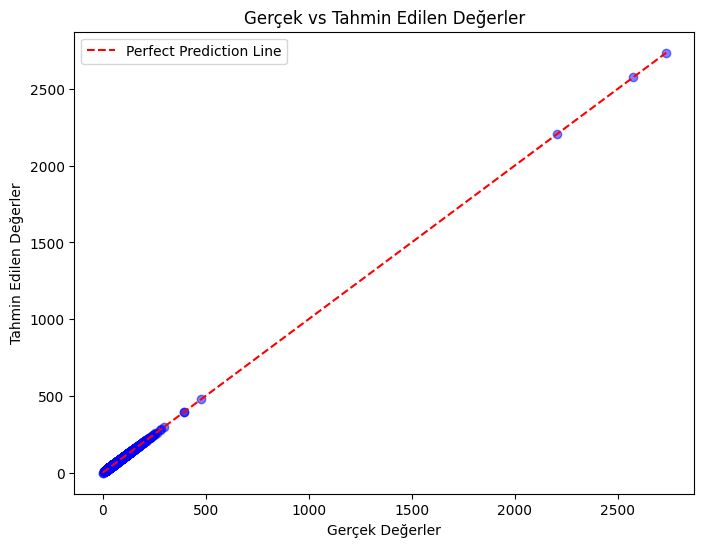

In [114]:
# Tahmin ve gerçek değerlerin karşılaştırılması
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect Prediction Line")
plt.title("Gerçek vs Tahmin Edilen Değerler")
plt.xlabel("Gerçek Değerler")
plt.ylabel("Tahmin Edilen Değerler")
plt.legend()
plt.show()

### Grafik Yorumu
1. **Kırmızı Kesik Çizgi ("Perfect Prediction Line"):** Her tahminin tam olarak gerçek değere eşit olduğu durumu gösterir.
2. **Mavi Noktalar (Tahmin Edilen ve Gerçek Değerler):** Mavi noktalar, modelin tahminleri ile gerçek değerleri temsil eder. Noktaların çoğu kırmızı kesik çizgi üzerinde veya çok yakınında bulunuyor. Bu gösteriyor ki, model yüksek doğrulukla çalışıyor ve tahminler genelde gerçek değerlere çok yakın.
3. **Yüksek Doğruluk:** Grafik neredeyse mükemmel bir çizgi oluşturuyor, bu da modelin R²=1.0 skorunu destekliyor.
4. **Yüksek Fiyatlar:** Sağ üst bölgedeki birkaç veri noktası modelin yüksek fiyatlarda da iyi performans gösterdiğini gösteriyor.

Bu grafik, modelin aşırı öğrenmiş (overfitting) olabileceğine işaret edebilir çünkü tahmin edilen değerler gerçek değerlere fazlasıyla yakın. Bundan dolayı, modelin performansını farklı veri setlerinde test ederek genellenebilirliğini kontrol edilmesi gerekir.

### 5.2 Rezidü (Hata) Dağılımı

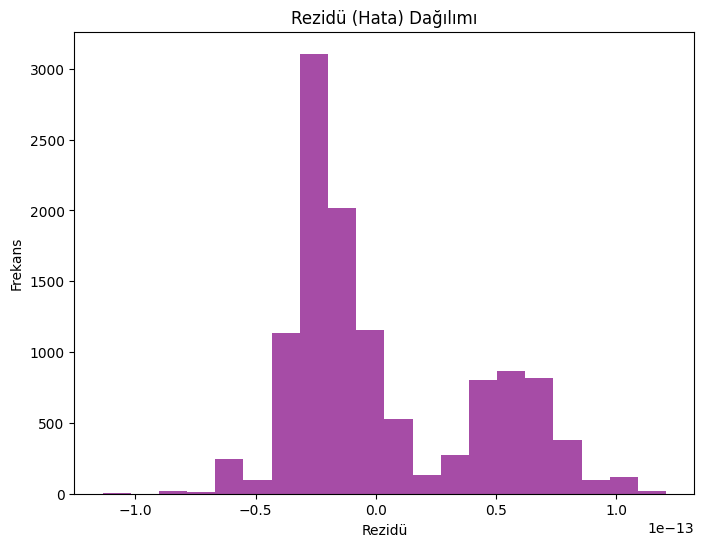

In [116]:
# Rezidü hesaplama
residuals = y_test - y_pred

# Rezidü dağılımı
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=20, alpha=0.7, color='purple')
plt.title("Rezidü (Hata) Dağılımı")
plt.xlabel("Rezidü")
plt.ylabel("Frekans")
plt.show()

Yukarıdaki grafiğe bakıldığında:
- Hataların büyük çoğunluğu **0** çevresinde yoğunlaşmış. Bu, modelin genel olarak tahminlerinde çok az hata yaptığını gösterir.
- Hataların histogramı, simetrik bir dağılıma sahiptir ve bir normal dağılıma yakın olduğu söylenebilir.
- Grafikte, çok büyük veya çok küçük hata değerlerinin olmadığı gözlemleniyor. Bu, modelin aşırı uç değerlere karşı dayanıklı olduğunu gösterir.
- Hataların sıfıra yakın olması ve simetrik bir şekilde dağılması, modelin tahminlerinin doğru ve dengeli olduğunu gösterir.

### 5.3 Model Performansını Tablo Olarak Görselleştirme

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


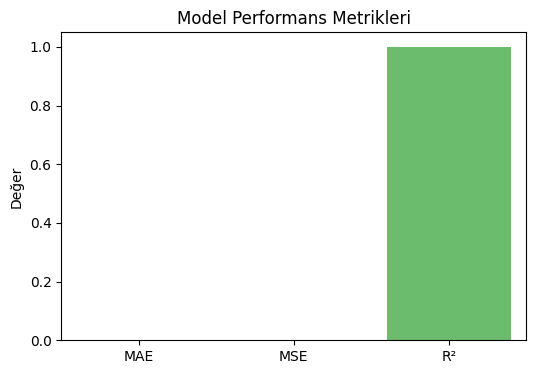

In [118]:
# Performans metriklerini görselleştirme
plt.figure(figsize=(6, 4))
sns.barplot(x=["MAE", "MSE", "R²"], y=[mae, mse, r2], palette="viridis")
plt.title("Model Performans Metrikleri")
plt.ylabel("Değer")
plt.show()

Yukarıdaki çıktıda bariz bir problem görünmektedir. **R² skoru** ile **MAE** ve **MSE** arasındaki değer farkı çok büyük olduğundan, R² skoru grafikte baskın görünmektedir. Bu durum, metriklerin doğru bir şekilde karşılaştırılmasını zorlaştırmaktadır. Ölçek farkını azaltmak için metrikler normalize edilmeli veya log dönüşümü uygulanmalıdır. Böylece metriklerin görselde dengeli bir şekilde temsil edilmesi mümkün olacaktır.

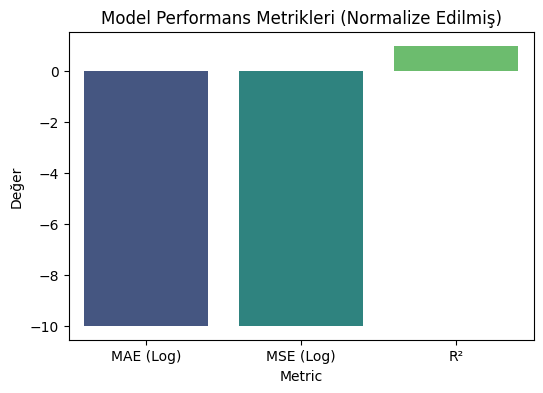

In [122]:
# MAE ve MSE için log dönüşümü (negatif log almayı önlemek için küçük bir sabit eklenir)
mae_log = np.log10(mae + 1e-10)
mse_log = np.log10(mse + 1e-10)

# Normalize edilmiş metriklerle grafik oluşturma
metrics_normalized = {
    "Metric": ["MAE (Log)", "MSE (Log)", "R²"],
    "Value": [mae_log, mse_log, r2]
}

metrics_df = pd.DataFrame(metrics_normalized)

plt.figure(figsize=(6, 4))
sns.barplot(x="Metric", y="Value", data=metrics_df, palette="viridis")
plt.title("Model Performans Metrikleri (Normalize Edilmiş)")
plt.ylabel("Değer")
plt.show()

Bu grafik, modelin performans metriklerini ölçek farklarını gidermek amacıyla **log dönüşümü** uygulanarak görselleştirmektedir. Normalize edilen metrikler arasında **MAE (Mean Absolute Error)**, **MSE (Mean Squared Error)** ve **R² skoru** yer almaktadır.
- **MAE ve MSE'nin düşük değerleri**, modelin tahmin hatalarının çok az olduğunu göstermektedir.
- **R²'nin 1.0 değeri**, modelin hedef değişkenin varyansını tamamen açıkladığını ifade eder.
- Normalize edilmiş bu grafik, farklı ölçeklerdeki metriklerin karşılaştırılmasını kolaylaştırmış ve modelin genel performansını daha net bir şekilde göstermiştir.

### 5.4 Özellik (PCA Bileşenleri) Katsayılarının Görselleştirilmesi

Bu grafik, modelin **PCA (Principal Component Analysis)** ile elde edilen bileşenlerine karşılık gelen katsayılarını göstermektedir. Her bir bileşenin katsayısı, modelde hedef değişken üzerindeki etkisini ifade etmektedir.

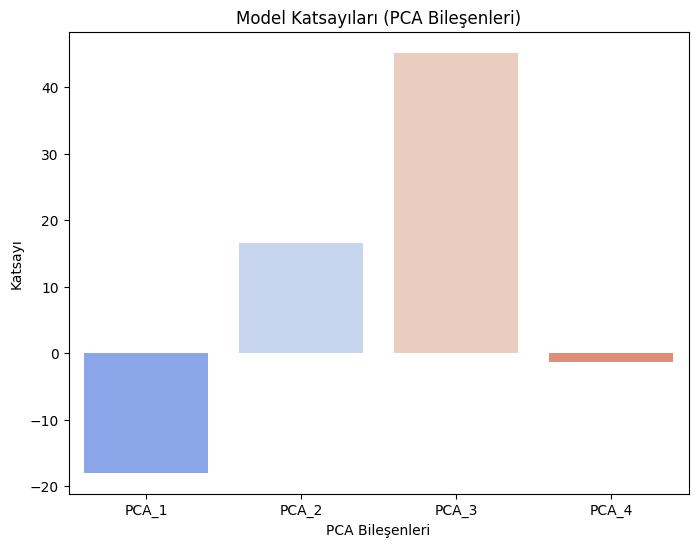

In [123]:
# Özellik katsayılarının görselleştirilmesi
plt.figure(figsize=(8, 6))
sns.barplot(x=coefficients["Feature"], y=coefficients["Coefficient"], palette="coolwarm")
plt.title("Model Katsayıları (PCA Bileşenleri)")
plt.xlabel("PCA Bileşenleri")
plt.ylabel("Katsayı")
plt.show()

- **PCA_3**, modelde en etkili bileşen olup, hedef değişken üzerindeki en büyük pozitif etkiye sahiptir.
- **PCA_1**, hedef değişken üzerinde en büyük negatif etkiyi yapmaktadır.
- Diğer bileşenler (PCA_2 ve PCA_4), model performansına katkıda bulunsa da, etkileri PCA_3 kadar güçlü değildir.

### 5.5 Kümülatif Varyans Oranlarının Görselleştirilmesi

Bu grafik, PCA (Principal Component Analysis) ile elde edilen bileşenlerin, veri setindeki toplam varyansın ne kadarını açıkladığını kümülatif olarak göstermektedir.

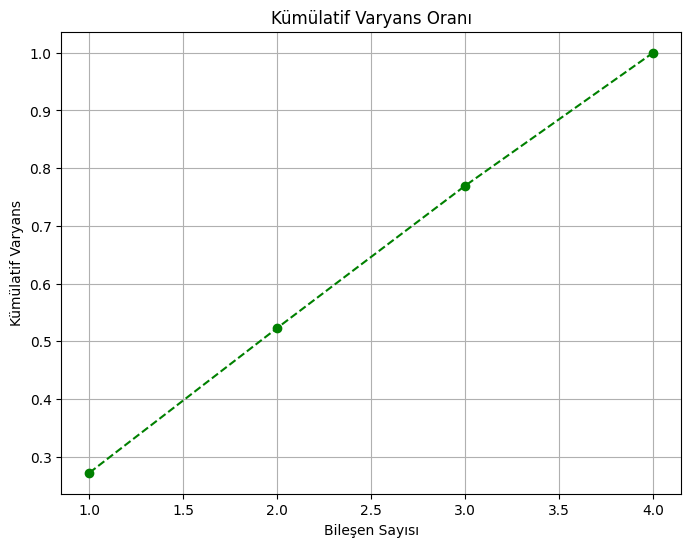

In [124]:
# Kümülatif varyans oranlarının görselleştirilmesi
cumulative_variance = pca.explained_variance_ratio_.cumsum()

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='green')
plt.title("Kümülatif Varyans Oranı")
plt.xlabel("Bileşen Sayısı")
plt.ylabel("Kümülatif Varyans")
plt.grid()
plt.show()

#### Grafik Yorumu:
1. **Bileşenlerin Varyans Açıklama Oranı:**
- İlk bileşen (PCA_1) yani grafikte gördüğümüz ilk nokta, toplam varyansın yaklaşık **%27.2**'sini açıklamaktadır.
- İkinci bileşen (PCA_2) ile birlikte toplam varyansın **%52.3**'ü açıklanmaktadır.
- Üçüncü bileşen (PCA_3) eklendiğinde bu oran **%76.9**'a ulaşmaktadır.
- Dördüncü bileşen (PCA_4) ile birlikte tüm varyansın **%100**'ü açıklanmaktadır.

2. **Kümülatif Varyans Artışı:**
- Grafikte kümülatif varyansın, her bir bileşenin eklenmesiyle birlikte düzenli bir şekilde arttığı görülmektedir.
- Dördüncü bileşene kadar, varyansın tamamının açıklandığı görülmektedir.


## Sonuç ve Değerlendirme
Proje kapsamında aşağıdaki sonuçlar elde edilmiştir:
1. PCA analizi ile veri setindeki varyansın **%77**’si yalnızca üç bileşenle açıklanmıştır.
2. Lineer regresyon modeli, R² = 1.0 ve neredeyse sıfır hata (MAE ve MSE) ile oldukça yüksek doğrulukla çalışmıştır.
3. Modelin görselleştirilmesi, hem tahminlerin hem de **hataların dengeli** olduğunu göstermiştir.
Bu sonuçlar, modelin hedef değişken üzerindeki etkili performansını ve PCA'nın boyut azaltma için uygun olduğunu göstermektedir.